# Trabalho Prático I - Problema de Transporte de Objeto

Descrição na [ementa](enunciado_trabalho_I_v2.pdf).

Neste cenário, um agente deve percorrer a grade 7x6, encontrar o objeto e transportá-lo até na base. Essa tarefa deve ser executada na menor quantidade de passos detempo possível. O agente não possui nenhum conhecimento prévio sobre o ambiente, o qual possui paredes, as quais ele não pode transpor. O agente também não possui conhecimento prévio sobre a localização do objeto. A localização inicial do agente, disposição das paredes e objeto são sempre fixas, conforme indicado na ilustração. A cada passo de tempo, o agente pode executar os seguintes movimentos na grade:
- mover para cima, baixo, esquerda ou direita;
- permanecer na mesma célula;

Este cenário apresenta algumas restrições de movimentação:
- O agente pode realizar apenas uma movimentação por passo de tempo;
- Se o agente escolher se mover para uma célula que não está vazia, seja por conta de uma parede ou objeto, ele não se move, i.e., permanece na mesma célula;
- Qualquer tentativa de locomoção para além da grade, resultará na não movimentação do agente;
- O objeto sé pode ser agarrado pela sua esquerda ou direita;
- Quando o agente ́e posicionado à direita ou esquerda do objeto, o objeto ée agarrado automaticamente;
- Uma vez agarrado o objeto, o agente não pode soltá-lo;
- O agente, quando agarrado ao objeto, só consegue se mover para uma nova célula desde que não haja nenhuma restrição de movimentação para o agente e objeto;

O episódio ée concluído automaticamente quando o objeto entra na base ou se atingir um número máximo de passos de tempo sem resolver a tarefa. Em ambos os casos, um novo episódio ́é iniciado, com o agente e objeto situados conforme abaixo.

In [80]:
# Libs necessária
import gym
from gym.envs.toy_text import discrete

import numpy as np

import sys

import matplotlib.pyplot as plt


# Estratégia

Pensei em algumas estratégias: Criar dois agentes, um que vai até o objeto e outro que vai com o objeto até o objetivo; Ou criar um agente que possui pontuação somente se chegar no objetivo com o objeto, porém, aqui precisamos de um modelo onde as transições não podem ser pré-definidas. Sendo assim o algoritmo foi alterado para identificar as transições possíveis de acordo com a posição do agente e sua interação com o ambiente (se tem ou não o objeto). Outro detalhe é o custo de andar (para objetivar o menor camino), pra isso foi importante colocar que um passo, mesmo que válido, aplica uma "punição" de -1.

Iniciamente usei o DiscreteEnv do Gym para isso. Mas foi necessário ampliar para busca das transições de forma dinâmica. Ainda extendi Env e reimplementei as partes do DiscreteEnv que me interessavam.

Outro detalhe da estratégia foram as paredes. Imaginei que poderia remover a opção de movimento válido nas paredes. Acredito que funciona pois diminui o espaço de transições possíveis. Porém, soa como "trapassa". Mas como está no enunciado, optei por seguir dessa forma. Pensei também em uma medida mais lógica que prática: objeto também custa. Então, segurar o objeto começa a custar tudo conforme o terreno onde está o objeto. Porém, não houve impacto na eficiência do algoritmo e a ideia foi abandonada.

In [101]:
# Montando o cenário 
# Exemplo 1: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e
# Exemplo 2: https://github.com/caburu/gym-cliffwalking/blob/master/gym_cliffwalking/envs/cliffwalking_env.py
# Exemplo 3: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py

class ObjectTransportEnv(discrete.Env):
    """
    O mapa é descrito com:
    _ : caminho livre
    o : posição inicial do agente ("ô" - agente com objeto)
    ^ : objeto a ser transportado
    $ : objetivo
    # : bloqueio
    O episódio termina chegar no objetivo.
    Sua recompensa é 100 chegar ao objetivo com o objeto e -1 para cada passo.
    Fora do mapa não é acessível. Mais regras na ementa acima.
    """

    metadata = {"render.modes": ["human", "ansi"]}

    # Constantes de identificação no mapa
    l_free_path = b'_'
    l_agent = b'o'
    l_object = b'^'
    l_goal = b'$'
    l_wall = b'#'

    # Possíveis movimentos de acordo com seu movimento
    actions_movements = [
        (0, -1) # left
        ,(-1, 0) # up
        ,(0, 1) # rigth
        ,(1, 0) # down
    ]

    # Passos do agente (pra renderização)
    agent_steps = []

    def __init__(self, desc):
        # Guarga o mapa, a quantidade de linhas e colunas e a faixa de premiação (o Env não precisa desse, mas achei melhor deixar)
        self.desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = self.desc.shape
        self.reward_range = (-1.0, 100.0)

        # 4 ações (cima, baixo, esquerda, direita)
        self.nA = len(self.actions_movements)
        # Espaço é o tamanho do mapa
        self.nS = self.nrow * self.ncol

        # Estado inicial (se tiver mais que um - escolhe um aleatório no reset)
        isd = np.array(self.desc == self.l_agent).astype("float64").ravel()
        isd /= isd.sum()
        self.isd = isd

        # Espaço de ações
        self.action_space = gym.spaces.Discrete(self.nA)
        # Não entendi pra que é usado no modelo. Acredito que é pra quando as posições iniciais são aleatórias. Porém, só é usado para ajudar em alguns cálculos
        self.observation_space = gym.spaces.Discrete(self.nS)

        # Define aleatoriedade pro modelo
        self.seed()

        # Define o estado inicial
        self.s = discrete.categorical_sample(self.isd, self.np_random)
        # Define o estado do objeto (que, se vazio, não foi pego ainda)
        self.os = None

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    # Função para dar uma previsão de movimento do vetor (ainda não o estado)
    def move(self, pos, action):
        incrow, inccol = action
        row, col = pos
        newpos = (row + incrow, col + inccol)
        return newpos

    # Conversão de linha/coluna para estado
    def rowcol_to_state(self, row, col):
        return row * self.ncol + col

    # Conversão de posição (linha/coluna) para estado
    def pos_to_state(self, pos):
        row, col = pos
        return self.rowcol_to_state(row, col)

    # Conversão de estado para linha/coluna
    def state_to_rowcol(self, s = None):
        _s = s or self.s
        return _s // self.ncol, _s % self.ncol

    # Verifica se o vetor está dentro dos limites do mapa
    def is_inside(self, pos):
        row, col = pos
        inside = row >= 0 and col >= 0 and row < self.nrow and col < self.ncol
        return inside

    # Verifica se a posição do vetor é válida
    def is_valid_pos(self, pos):
        inside = self.is_inside(pos)
        walkable = False
        if inside:
            row, col = pos
            # Se está segurando, o ponto original do objeto não é mais o mesmo. Então, pode ocupar.
            valids = [self.l_free_path, self.l_goal, (self.l_object if self.os else b'')]
            walkable = self.desc[row, col] in valids
        return inside and walkable

    # Verifica se a ação solicitada no Qlearning é possível
    def is_valid_current_action(self, action):
        transitions = self.possible_actions()
        return action in transitions

    # Pega uma ação aleatória dentre as possíveis
    def sample_from_available_current_actions(self):
        transitions = self.possible_actions()
        keys = list(transitions.keys())
        value = self.np_random.choice(keys)
        return value

    # Obtém as transições possíveis de uma ação (atualmente é só uma com 100% de certeza)
    def action_possible_transitions(self, pos, action):
        newpos = self.move(pos, action)
        newpos_obj = None
        objpos = self.state_to_rowcol(self.os) if self.os else None
        
        if not self.is_valid_pos(newpos):
            return None # Se estiver fora do mapa já cai fora

        # Se já estiver segurando o objeto.
        if objpos:
            newpos_obj = self.move(objpos, action) # Objeto move na mesma direção do agente
            if not self.is_valid_pos(newpos_obj):
                return None # Se o objeto estiver fora do mapa ou na parede, também não é um caminho válido
        else:
            # Checa se começou a segurar o objeto à esquerda ou direita
            for action_check in [self.actions_movements[0], self.actions_movements[2]]:
                newpos_obj_temp = self.move(newpos, action_check)
                if self.is_inside(newpos_obj_temp) and self.desc[newpos_obj_temp[0], newpos_obj_temp[1]] == self.l_object:
                    newpos_obj = newpos_obj_temp

        newrow, newcol = newpos
        newletter = self.desc[newrow, newcol]
        
        reward = -1.0
        done = False
        # "Pronto" se chegar no objetivo com o objeto
        if newpos_obj:
            done = bytes(newletter) in [self.l_goal]
            if done:
                reward = 100.0

        prob = 1.0 # Tudo é 100% de probabilidade pq não tem esse tipo de medição no nosso modelo

        newstate = self.pos_to_state(newpos)
        newobjectstate = (self.pos_to_state(newpos_obj) if newpos_obj else None)
        
        return prob, newstate, reward, done, newobjectstate

    # Busca as ações possíveis e probabilidades das transições no espaço de ações
    def possible_actions(self, pos = None):
        _pos = pos or self.state_to_rowcol(self.s)
        _p = {}
        for index, action in enumerate(self.actions_movements):
            result = self.action_possible_transitions(_pos, action)
            if result:
                _p[index] = result
        return _p

    # Reinicia o mapa
    def reset(self):
        self.s = discrete.categorical_sample(self.isd, self.np_random)
        self.os = None
        self.agent_steps = [] # para renderizar o caminho
        return int(self.s)

    # Próximo passo do mapa
    def step(self, action_index):
        action = self.actions_movements[action_index]
        pos = self.state_to_rowcol()
        transitions = [self.action_possible_transitions(pos, action)]
        i = discrete.categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d, os = transitions[i]
        self.s = s
        self.os = os
        self.agent_steps.append(self.s)
        return (int(s), r, d, {"prob": p})

    # Desenha o mapa da tela ( pelo console do bash tem cores :-O )
    def render(self, mode="human"):
        outfile = StringIO() if mode == "ansi" else sys.stdout

        desc = self.desc.tolist()
        desc2 = desc[:]
        colors = {
            self.l_goal: 'blue',
            self.l_agent: 'red',
            self.l_wall: 'white',
            self.l_object: 'magenta',
        }
        
        for row in range(len(desc)):
            for col in range(len(desc[row])):
                sb = desc[row][col]
                color = colors.get(sb)
                ss = sb.decode('utf-8')
                desc2[row][col] = gym.utils.colorize(ss, color, highlight=True) if color else ss

        if self.agent_steps:
            for _s in self.agent_steps:
                row, col = self.state_to_rowcol(_s)
                color = colors.get(desc[row][col])
                walked = "~"
                desc2[row][col] = gym.utils.colorize(walked, color, highlight=True) if color else walked
            text = self.l_agent.decode('utf-8')
            if self.os:
                text = u'ô'
            desc2[row][col] = gym.utils.colorize(text, 'cyan', highlight=True)

        outfile.write("\n".join(" ".join(line) for line in desc2) + "\n")

        if mode != "human":
            with closing(outfile):
                return outfile.getvalue()

t1_map = [
    "__$$$__",
    "___#___",
    "___^___",
    "_______",
    "##_####",
    "o_____#"
]

t1_env = ObjectTransportEnv(t1_map)
t1_env.reset()
t1_env.render()


_ _ $ $ $ _ _
_ _ _ # _ _ _
_ _ _ ^ _ _ _
_ _ _ _ _ _ _
# # _ # # # #
o _ _ _ _ _ #


In [102]:
# Código de Qlearning roubado discaradamente do exemplo de cliff da última aula. Porém, com pequenas alterações para atender nosso modelo.
def Qlearning(environment, num_episodes=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.01, max_steps=100):
  
  # Inicializa o Q-table
  Q = np.zeros((environment.observation_space.n, environment.action_space.n))
  
  # Listas adicionais para guardar as recompensas e epsilons
  rewards = []
  epsilons = []

  # Variável teste para renderizar os caminhos indo melhorando
  #last_accumulated_reward = -999999

  # Episódios
  for episode in range(num_episodes):
      
      # Reinicia o mapa para mais um episódio
      state = environment.reset()

      # Inicializa a recompensa acumulada no episódio
      accumulated_reward = 0
      
      # Limite de passos no episódio (sem atingir o objetivo)
      for step in range(max_steps):
          action = None

          # epsilon-greedy action selection
          # exploit with probability 1-epsilon
          if np.random.uniform(0, 1) > epsilon:
              action = np.argmax(Q[state,:])
              # Adicionado essa condição pois, em modelos recém inicializados a opção greedy pode apontar para uma ação impossível. Como uma parede.
              if not environment.is_valid_current_action(action):
                action = None
          
          # explore with probability epsilon
          if not action:
              #action = environment.action_space.sample()
              action = environment.sample_from_available_current_actions()

          # perform the action and observe the new state and corresponding reward
          new_state, reward, done, info = environment.step(action)

          # update the Q-table
          Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
          
          # update the accumulated reward
          accumulated_reward += reward

          # update the current state
          state = new_state

          # end the episode when it is done
          if done == True:
              break
      
      # decay exploration rate to ensure that the agent exploits more as it becomes experienced
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)
      
      # update the lists of rewards and epsilons
      rewards.append(accumulated_reward)
      epsilons.append(epsilon)

      # Teste pra mostrar cada caminho melhor
      # if accumulated_reward > last_accumulated_reward:
      #   environment.render()
      #   print('>' * 10, episode, last_accumulated_reward, '->', accumulated_reward)
      #   last_accumulated_reward = accumulated_reward 

  # render the environment
  environment.render()
  print(accumulated_reward)
    
  # return the list of accumulated reward along episodes
  return rewards

In [105]:
%%time

num_episodes=100
max_steps=100
alpha=0.3 # Peso para atualização do novo caminho descoberto (taxa de aprendizagem)
gamma=0.9 # Fator de desconto
epsilon=1.0
decay_epsilon=0.1

# run Q-learning
rewards = Qlearning(t1_env, num_episodes, alpha, gamma, epsilon, decay_epsilon, max_steps=max_steps)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 10 episodes): " + str(sum(rewards[-10:])/10))

_ _ $ $ ô _ _
_ _ _ # ~ _ _
_ _ ~ ~ ~ _ _
_ _ ~ _ _ _ _
# # ~ # # # #
o ~ ~ _ _ _ #
92.0
Average reward (all episodes): 78.84
Average reward (last 10 episodes): 92.0
Wall time: 145 ms


# Solução

A solução me surpreendeu. 

Achava que o melhor caminho seria pela esquerda da parede em frente ao objetivo. O algoritmo conseguiu achar o caminho pela direita e ambos são os melhores. No meu exercício mental, o objeto tinha que atingir o objetivo, mas no algoritmo isso não está implementado, e, não está nas regras.

# Observações

A solução implementada permite um mapa flexível com vários objetos e se entenderia dinamicamente.

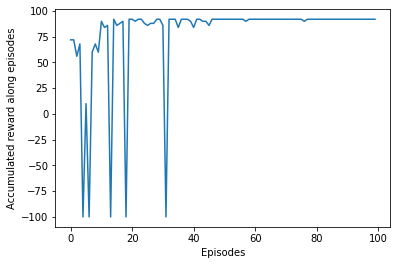

In [106]:
# Curva de convergência
plt.plot(range(num_episodes), rewards)
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward along episodes')
plt.show()